In [1]:
from Signal_generator.generate_signal import generate_X_matrix
from Algorithmes.beamforming import beamforming_method
from Signal_generator.generate_signal import generate_A_matrix
from Signal_generator.generate_signal import generate_S_matrix
from Signal_generator.generate_signal import generate_noise
from Signal_generator.generate_signal import generate_R_hat
from Signal_generator.generate_signal import generate_R_hat_with_phase
from Algorithmes.music import music_method
from Algorithmes.music import estimate_angles
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split 
import numpy as np
import torch
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import itertools
from torchsummary import summary
from numpy.linalg import eigh
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
from torchsummary import summary
import math
import random
from sklearn.metrics import mean_squared_error
from Algorithmes.music import generate_steering_vector
from Plots.draw_plot import plot_single_music

In [2]:
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():  
    torch.cuda.manual_seed_all(42)

In [3]:
import numpy as np

def calculate_music_spectrum(R_hat, nbSensors, nbSources, angles_range):
    # Calculer les vecteurs propres et les valeurs propres
    _, eigenvectors = np.linalg.eigh(R_hat)
    # Sélectionner les k plus grandes valeurs propres
    noise_subspace = eigenvectors[:, :-nbSources]
    music_spectrum = np.zeros_like(angles_range, dtype=float)
    for idx, theta in enumerate(angles_range):
        steering_vector = generate_steering_vector(nbSensors, theta)
        music_spectrum[idx] = 1 / np.linalg.norm(noise_subspace.conj().T @ steering_vector)

    return music_spectrum

perturbation_parameter_sd = 0

In [45]:
import itertools

def generate_combinations(phi_max, rho, nb_sources):
    """Cette fonction sert à générer toutes les combinaisons d'angles possibles dans la plage de résolution"""
    # Générer une plage de valeurs possibles pour les signaux
    values = list(range(-int(phi_max / rho), int(phi_max / rho) + 1))
    
    # Générer toutes les combinaisons possibles de signaux
    all_combinations = list(itertools.product(values, repeat=nb_sources))
    
    # Supprimer les combinaisons où l'ordre ne compte pas et où deux signaux ont la même valeur
    unique_combinations = {tuple(sorted(combination)) for combination in all_combinations if len(set(combination)) == nb_sources}
    
    return list(unique_combinations)

#
Q = 4
N = 2**12
phi_max = 60
rho = 1
nbSources = 2 # Nombre de sources
nbSensors = 9 # Nombre de capteurs
nbTimePoints = 100 # Nombre de points temporels
signal_noise_ratio = 10 # Rapport signal sur bruit en décibels. Si 'False', cela revient à une absence totale de bruit.
theta1 = -20 # Angle entre la perpendiculaire à la ligne de capteurs, et la source 1
theta2 = 20 # Angle entre la perpendiculaire à la ligne de capteurs, et la source 2
var_ratio = [1] # Liste qui donne le rapport entre la variance du signal 1 et celui des autres sources (ex: [2, 3] signifie que la source 2 a une variance 2 fois plus grande que la source 1, et la source 3 a une variance 3 fois plus grande que la source 1)
correlation_List = [0] # Liste des corrélations. Il y a une corrélation nécéssaire pour chaque paire distincte de sources différentes: 0 pour 1 source, 1 pour 2 sources, 3 pour 3 sources, 6 pour 4 sources etc...
# Ordre de remplisage de la correlation_List: de gauche à droite et ligne par ligne, moitié haut-droite de la matrice uniquement, puis symétrie de ces valeurs pour la moitié bas-gauche
perturbation_parameter_sd = 0 # Écart-type de la distribution normale qui génère les erreurs de calibration des capteurs
J_alpha = 100
J_beta = 10

def generate_deepmusic_partitioned_data(J_alpha, J_beta, nbSensors, nbSources, T, SNR_TRAIN, Q, N, phi_max, rho, correlation_List, var_ratio):
    training_data_sets = [[] for _ in range(Q)]
    full_theta = np.linspace(-phi_max, phi_max, N)
    L = N // Q

    for signal_noise_ratio in SNR_TRAIN:
        for j_alpha in range(J_alpha):
            # Répartir les sources dans les sous-régions
            source_angles = []
            for q in range(min(Q, nbSources)):
                # Déterminer les limites de la sous-région
                start_theta = -phi_max + q * (2 * phi_max / Q)
                end_theta = start_theta + (2 * phi_max / Q)
                # Générer un angle aléatoire dans la sous-région
                angle = np.random.uniform(start_theta, end_theta)
                source_angles.append(angle)

            for j_beta in range(J_beta):
                varList = np.ones(nbSources).tolist()
                correlation_List = np.zeros(nbSources * (nbSources - 1) // 2).tolist()
                X = generate_X_matrix(nbSources=nbSources, nbSensors=nbSensors, nbTimePoints=T, thetaList=source_angles, var_ratio=var_ratio, correlation_List=correlation_List, signal_noise_ratio=signal_noise_ratio, perturbation_parameter_sd=0)
                R_hat = generate_R_hat(X)
                R_hat_with_phase = generate_R_hat_with_phase(X)
                
                full_music_spectrum = calculate_music_spectrum(R_hat, nbSensors, nbSources, full_theta)

                for q in range(Q):
                    # Sampling MUSIC spectrum for the q-th subregion
                    start_index = q * L
                    end_index = (q + 1) * L if q != Q - 1 else N
                    pq = full_music_spectrum[start_index:end_index]
                
                    input_data = R_hat_with_phase
                    output_data = pq
                    training_data_sets[q].append((input_data, output_data))

    return training_data_sets


full_theta = np.linspace(- phi_max , phi_max, N)
# Example usage
SNR_TRAIN = [0]  # Different SNR levels for training
training_datasets = generate_deepmusic_partitioned_data(J_alpha=J_alpha,J_beta=J_beta,nbSensors=nbSensors, nbSources=nbSources, T=nbTimePoints, SNR_TRAIN=SNR_TRAIN, Q=Q, N=N, phi_max=phi_max, rho=rho, correlation_List=correlation_List, var_ratio=var_ratio)


In [34]:
len(training_datasets[0][100])

2

In [5]:
subinterval_length = N//Q
thetaList = [np.random.uniform(-phi_max + q * subinterval_length, -phi_max + (q + 1) * subinterval_length) for q in range(nbSources)]
thetaList

[698.6950068869792, 1663.1218260868106]

In [6]:
input_data, output_data = training_datasets[1][978]
a = []
for i in range(0,Q-1):
    input_data, output_data = training_datasets[i][978]
    a.append(output_data)

IndexError: list index out of range

In [7]:
def reconstruct_music_spectrum(segments, Q, N):
    """
    Reconstruct the full music spectrum from its segmented parts.

    Args:
    segments (list of ndarrays): The segmented parts of the music spectrum.
    Q (int): The number of segments.
    N (int): The total number of points in the full music spectrum.

    Returns:
    ndarray: The reconstructed music spectrum.
    """
    # Initialize the reconstructed spectrum with zeros
    reconstructed_spectrum = np.zeros(N, dtype=float)
    
    # Length of each segment
    segment_length = N // Q

    # Iterate over each segment and place it in the reconstructed spectrum
    for q, segment in enumerate(segments):
        start_index = q * segment_length
        if q < Q - 1:
            # For all but the last segment, use the segment length
            end_index = start_index + segment_length
        else:
            # For the last segment, it can be longer if N is not divisible by Q
            end_index = N
        # Make sure segment is the correct shape
        segment = segment[:end_index - start_index]
        reconstructed_spectrum[start_index:end_index] = segment
    
    return reconstructed_spectrum
    

reconstruct_music_spectrum(a, Q, N)
print(type(a))
plot_single_music(reconstruct_music_spectrum(a, Q, N),np.linspace(-60,60,N))
for i in range(0,Q-1):
    input_data, output_data = training_datasets[i][978]
    plot_single_music(output_data,np.linspace(-60,60,N//Q))

NameError: name 'a' is not defined

In [46]:
def normalize_data(training_data_sets):
    # Calculer la moyenne et l'écart-type pour la normalisation
    all_data = np.concatenate([data[0] for q_data in training_data_sets for data in q_data], axis=0)
    mean = np.mean(all_data, axis=(0, 2), keepdims=True)
    std = np.std(all_data, axis=(0, 2), keepdims=True)

    # Normaliser les données
    normalized_training_data_sets = []
    for q_data in training_data_sets:
        normalized_q_data = []
        for input_data, output_data in q_data:
            normalized_input = (input_data - mean) / std
            normalized_q_data.append((normalized_input, output_data))
        normalized_training_data_sets.append(normalized_q_data)

    return normalized_training_data_sets

# Exemple d'utilisation
normalized_training_datasets = normalize_data(training_datasets)

In [47]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

class DeepMusicDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        input_data, output_data = self.data[idx]
        return torch.tensor(input_data, dtype=torch.float32), torch.tensor(output_data, dtype=torch.float32)

def create_loaders_for_subregion(data, batch_size=120, validation_split=0.2, test_split=0.2):
    # Séparation des données en ensembles d'entraînement, de validation et de test
    train_data, test_data = train_test_split(data, test_size=test_split, random_state=42)
    train_data, val_data = train_test_split(train_data, test_size=validation_split, random_state=42)

    # Création des instances de DeepMusicDataset
    train_dataset = DeepMusicDataset(train_data)
    print(len(train_dataset)/batch_size)
    print(len(train_dataset))
    val_dataset = DeepMusicDataset(val_data)
    print(len(val_dataset)/batch_size)
    print(len(val_dataset))
    test_dataset = DeepMusicDataset(test_data)
    print(len(test_dataset)/batch_size)
    print(len(test_dataset))

    # Création des DataLoader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

    return train_loader, val_loader, test_loader

# Création des DataLoader pour chaque sous-région
loaders_per_subregion = [create_loaders_for_subregion(normalized_training_datasets[q]) for q in range(Q)]

5.333333333333333
640
1.3333333333333333
160
1.6666666666666667
200
5.333333333333333
640
1.3333333333333333
160
1.6666666666666667
200
5.333333333333333
640
1.3333333333333333
160
1.6666666666666667
200
5.333333333333333
640
1.3333333333333333
160
1.6666666666666667
200


In [48]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DeepMusicModel(nn.Module):
    def __init__(self, output_size):
        super(DeepMusicModel, self).__init__()
        # Define the first convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=256, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(num_features=256)
        
        # Define the second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm2d(num_features=256)
        
        # Define the third convolutional layer
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(num_features=256)
        
        # Define the fourth convolutional layer
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(num_features=256)
        
        # Global average pooling layer
        self.global_pooling = nn.AdaptiveAvgPool2d(1)
        
        # Fully connected layer
        self.fc1 = nn.Linear(256, 4096)
        self.fc2= nn.Linear(in_features=4096, out_features=2048)
        self.fc3 = nn.Linear(in_features=2048, out_features=1024)
        self.fc4 = nn.Linear(in_features=1024, out_features=output_size)
        
        # Dropout layer
        self.dropout = nn.Dropout(p=0.2)

        # Softmax layer 
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # Apply the first convolutional layer and normalization, followed by ReLU
        x = F.relu(self.bn1(self.conv1(x)))
        
        # Apply the second convolutional layer and normalization, followed by ReLU
        x = F.relu(self.bn2(self.conv2(x)))
        
        # Apply the third convolutional layer and normalization, followed by ReLU
        x = F.relu(self.bn3(self.conv3(x)))
        
        # Apply the fourth convolutional layer and normalization, followed by ReLU
        x = F.relu(self.bn4(self.conv4(x)))
        
        # Apply global average pooling
        x = self.global_pooling(x)
        
        # Reshape for the fully connected layer
        x = x.view(x.size(0), -1)
        
        # Apply the fully connected layer
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)

        # Apply the dropout layer
        x = self.dropout(x)

        # Apply the softmax layer
        x = self.softmax(x)

        return x


In [49]:
#Définition du device

device = (
    "gpu"
    if torch.cuda.is_available()
    else "cpu"
)

print(f"Using {device} device")

Using cpu device


In [51]:
import torch
import time
import numpy as np
from scipy.signal import find_peaks
import torch.nn.functional as F

def calculate_accuracy(predicted_spectrum, target_spectrum, angles_range, nbSources, peak_tolerance):
    """
    Calculate accuracy for a single predicted and target spectrum.
    
    :param predicted_spectrum: Predicted MUSIC spectrum (1D NumPy array).
    :param target_spectrum: True MUSIC spectrum (1D NumPy array).
    :param angles_range: The range of angles over which the MUSIC spectrum is calculated.
    :param nbSources: The number of sources (peaks) to consider.
    :param peak_tolerance: The tolerance for considering a predicted peak to match a target peak.
    :return: Accuracy as a float.
    """
    # Estimate angles from the predicted and target spectra
    estimated_angles = estimate_angles(nbSources, predicted_spectrum, angles_range)
    true_angles = estimate_angles(nbSources, target_spectrum, angles_range)

    # Compare the estimated angles with the true angles
    correct_predictions = sum(1 for est_angle in estimated_angles if np.any(np.abs(true_angles - est_angle) <= peak_tolerance))
    accuracy = correct_predictions / nbSources if nbSources > 0 else 0
    return accuracy



def train_and_evaluate_spectrum(loaders_per_subregion, epochs, nbSources, angles_range, peak_tolerance=5):
    models = []
    train_loss_list = []
    val_loss_list = []
    val_mse_list = []
    metrics = {
        'train_loss': [],
        'val_loss': [],
        'val_mse': [],
        'avg_mse_per_epoch_val': [],
        'avg_mse_per_epoch_train': [],
        'total_mse': None,
        'training_time': None
    }

    # Training configuration
    initial_lr = 0.1
    lr_decay_factor = 0.5
    lr_decay_epoch = 10
    early_stopping_patience = 3

    start_time = time.time()  # Start time for training
    for train_loader, val_loader, test_loader in loaders_per_subregion:
        model = DeepMusicModel(N//Q)
        optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr)
        criterion = torch.nn.MSELoss()

        best_val_mse = float('inf')
        epochs_no_improve = 0

        for epoch in range(epochs):
            # Adjust learning rate
            if epoch % lr_decay_epoch == 0 and epoch > 0:
                for param_group in optimizer.param_groups:
                    param_group['lr'] *= lr_decay_factor

            # Training loop
            model.train()
            train_loss = 0
            for inputs, targets in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets).item()
                optimizer.step()
                train_loss += loss
                
            avg_train_loss = train_loss / len(train_loader)
            train_loss_list.append(avg_train_loss)
            metrics["train_loss"].append(avg_train_loss)
            # Validation loop
            model.eval()
            val_loss, val_mse = 0, 0
            with torch.no_grad():
                for inputs, targets in val_loader:
                    outputs = model(inputs)
                    val_loss += criterion(outputs, targets).item()
                    val_mse += F.mse_loss(outputs, targets).item()

            avg_val_loss = val_loss / len(val_loader)
            avg_val_mse = val_mse / len(val_loader)
            val_loss_list.append(avg_val_loss)
            metrics["val_loss"].append(avg_val_loss)
            val_mse_list.append(avg_val_mse)
            metrics["val_mse"].append(avg_val_mse)

            # Early stopping
            if avg_val_mse < best_val_mse:
                best_val_mse = avg_val_mse
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
                if epochs_no_improve == early_stopping_patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break

        models.append(model)

    # Calculate training time
    end_time = time.time()
    training_time = end_time - start_time
    print(f"Training time: {training_time} seconds")

    # Test set evaluation
    concatenated_outputs = []
    concatenated_targets = []

    for model, test_loader in zip(models, [x[2] for x in loaders_per_subregion]):
        model.eval()
        with torch.no_grad():
            for inputs, targets in test_loader:
                outputs = model(inputs)

                # Concatenate outputs and targets
                concatenated_outputs.append(outputs)
                concatenated_targets.append(targets)

    # Calculate the average MSE per epoch on the validation set
    avg_mse_per_epoch_val = []
    for epoch in range(epochs):
        epoch_mse = []
        for i, model in enumerate(models):
            # Determine the actual number of epochs the model was trained for
            actual_epochs = len(train_loss_list[i * epochs:(i + 1) * epochs])
            if epoch < actual_epochs:
                epoch_mse.append(train_loss_list[i * epochs + epoch])
        avg_mse_per_epoch_val.append(np.mean(epoch_mse))
        metrics["avg_mse_per_epoch_train"].append(np.mean(epoch_mse))
        

    print("Average MSE per epoch on validation set:", avg_mse_per_epoch_val)

    # Calculate the average MSE per epoch on the training set
    avg_mse_per_epoch_train = []
    for epoch in range(epochs):
        epoch_mse = []
        for i, model in enumerate(models):
            # Determine the actual number of epochs the model was trained for
            actual_epochs = len(val_mse_list[i * epochs:(i + 1) * epochs])
            if epoch < actual_epochs:
                epoch_mse.append(val_mse_list[i * epochs + epoch])
        avg_mse_per_epoch_train.append(np.mean(epoch_mse))
        metrics["avg_mse_per_epoch_train"].append(np.mean(epoch_mse))

    print("Average MSE per epoch on training set:", avg_mse_per_epoch_train)

    # Determine the maximum size of all targets
    max_size = max(target.size(1) for target in concatenated_targets)
    # Pad each target tensor to the maximum size
    padded_targets = [F.pad(target, (0, max_size - target.size(1))) for target in concatenated_targets]

    padded_outputs = [F.pad(output, (0, max_size - output.size(1))) for output in concatenated_outputs]

    # Concatenate the padded targets into a single tensor
    concatenated_targets = torch.cat(padded_targets, dim=0)
    concatenated_outputs = torch.cat(padded_outputs, dim=0)

    # Compute MSE for concatenated outputs and targets
    total_mse = F.mse_loss(concatenated_outputs, concatenated_targets).item()
    metrics['total_mse'] = total_mse
    metrics['training_time'] = training_time
    print(f'Average Training Loss: {np.mean(train_loss_list):.4f}')
    print(f'Average Validation Loss: {np.mean(val_loss_list):.4f}')
    print(f'MSE on Test Set: {total_mse:.4f}')
    print(f'Training time: {training_time}')
    return models, metrics
# Example usage
model1_results = train_and_evaluate_spectrum(loaders_per_subregion=loaders_per_subregion, epochs=10, nbSources=nbSources, angles_range=full_theta, peak_tolerance=5)

Early stopping at epoch 8
Early stopping at epoch 4
Early stopping at epoch 4
Early stopping at epoch 6
Training time: 22.779598474502563 seconds
Average MSE per epoch on validation set: [0.6092191845178604, 0.6072463139891624, 0.5270665533840656, 0.5304759681224823, 0.5296136200428009, 0.5288704015314579, 0.5247805006802082, 0.5237041510641575, 0.4418217405676842, 0.44349342584609985]
Average MSE per epoch on training set: [0.5826438019673029, 0.5826438019673029, 0.5213162936270237, 0.5213162638247013, 0.5213162377476692, 0.5213162936270237, 0.5158897861838341, 0.5158897861838341, 0.4151046760380268, 0.4151046797633171]
Average Training Loss: 0.5340
Average Validation Loss: 0.5177
MSE on Test Set: 0.4895
Training time: 22.779598474502563


In [53]:
from Models.compare import *
models, _ = model1_results
save_models_hyperparams_and_metadata(models, hyperparameters_list=[{"A" : "a"} for _ in range(Q)], metadata_list=[{"A" : "a"} for _ in range(Q)], directory_name="DeepMusic_subregion_2")

RuntimeError: [enforce fail at inline_container.cc:424] . unexpected pos 4817152 vs 4817048

In [ ]:
models

[DeepMusicModel(
   (conv1): Conv2d(3, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
   (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (conv2): Conv2d(256, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
   (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (conv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (conv4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (global_pooling): AdaptiveAvgPool2d(output_size=1)
   (fc1): Linear(in_features=256, out_features=4096, bias=True)
   (fc2): Linear(in_features=4096, out_features=2048, bias=True)
   (fc3): Linear(in_features=2048, out_features=1024, bias=True)
   (fc4): Linear(in_features=1024, out_features=512, 

In [ ]:
import time
epochs = 10
models = []
train_loss_list = []
val_loss_list = []
val_mse_list = []
metrics = {
        'train_loss': [],
        'val_loss': [],
        'val_mse': [],
        'avg_mse_per_epoch_val': [],
        'avg_mse_per_epoch_train': [],
        'total_mse': None,
        'training_time': None
    }

    # Training configuration
initial_lr = 0.01
lr_decay_factor = 0.5
lr_decay_epoch = 10
early_stopping_patience = 3
loss = nn.MSELoss()

start_time = time.time()  # Start time for training
for train_loader, val_loader, test_loader in loaders_per_subregion:
    model = DeepMusicModel(N//Q)
    optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr)
    criterion = torch.nn.MSELoss()

    best_val_mse = float('inf')
    epochs_no_improve = 0

    for epoch in range(epochs):
        # Adjust learning rate
        if epoch % lr_decay_epoch == 0 and epoch > 0:
            for param_group in optimizer.param_groups:
                param_group['lr'] *= lr_decay_factor

        # Training loop
        model.train()
        train_loss = 0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            print(targets.shape,outputs.shape)

torch.Size([120, 512]) torch.Size([120, 4096])
torch.Size([120, 512]) torch.Size([120, 4096])
torch.Size([120, 512]) torch.Size([120, 4096])
torch.Size([120, 512]) torch.Size([120, 4096])
torch.Size([120, 512]) torch.Size([120, 4096])
torch.Size([120, 512]) torch.Size([120, 4096])
torch.Size([120, 512]) torch.Size([120, 4096])
torch.Size([120, 512]) torch.Size([120, 4096])
torch.Size([120, 512]) torch.Size([120, 4096])
torch.Size([120, 512]) torch.Size([120, 4096])
torch.Size([120, 512]) torch.Size([120, 4096])
torch.Size([120, 512]) torch.Size([120, 4096])
torch.Size([120, 512]) torch.Size([120, 4096])
torch.Size([120, 512]) torch.Size([120, 4096])
torch.Size([120, 512]) torch.Size([120, 4096])
torch.Size([120, 512]) torch.Size([120, 4096])
torch.Size([120, 512]) torch.Size([120, 4096])
torch.Size([120, 512]) torch.Size([120, 4096])
torch.Size([120, 512]) torch.Size([120, 4096])
torch.Size([120, 512]) torch.Size([120, 4096])
torch.Size([120, 512]) torch.Size([120, 4096])
torch.Size([1

In [ ]:
class SpectrumReconstructionModel(nn.Module):
    def __init__(self, Q, N):
        """
        Initialize the model.

        Args:
        Q (int): The number of segments.
        N (int): The total number of points in the full music spectrum.
        """
        super(SpectrumReconstructionModel, self).__init__()
        self.Q = Q
        self.N = N

        # You can add layers here if you want to further process the segments before reconstruction
        # For example, a fully connected layer for each segment
        # self.fc_layers = nn.ModuleList([nn.Linear(segment_size, segment_size) for _ in range(Q)])
    
    def forward(self, segments):
        """
        Forward pass for reconstructing the spectrum.

        Args:
        segments (list of Tensors): Outputs of the trained models, each a segment of the spectrum.

        Returns:
        Tensor: The reconstructed music spectrum.
        """
        reconstructed_spectrum = torch.zeros(self.N)

        segment_length = self.N // self.Q

        for q, segment in enumerate(segments):
            start_index = q * segment_length
            if q < self.Q - 1:
                end_index = start_index + segment_length
            else:
                end_index = self.N

            # Optionally, further process each segment
            # segment = self.fc_layers[q](segment)

            reconstructed_spectrum[start_index:end_index] = segment[:end_index - start_index]

        return reconstructed_spectrum

In [ ]:
predicted_segments = []
for model in models:
    model.eval()  # Mettre le modèle en mode évaluation
    with torch.no_grad():
        predicted_segment = model(inputs)
        predicted_segments.append(predicted_segment.detach().numpy())  # Convertir en numpy si nécessaire

# Utiliser SpectrumReconstructionModel pour la reconstruction
reconstruction_model = SpectrumReconstructionModel(Q, N)
reconstructed_spectrum = reconstruction_model(predicted_segments)

[-7.1  6.9]


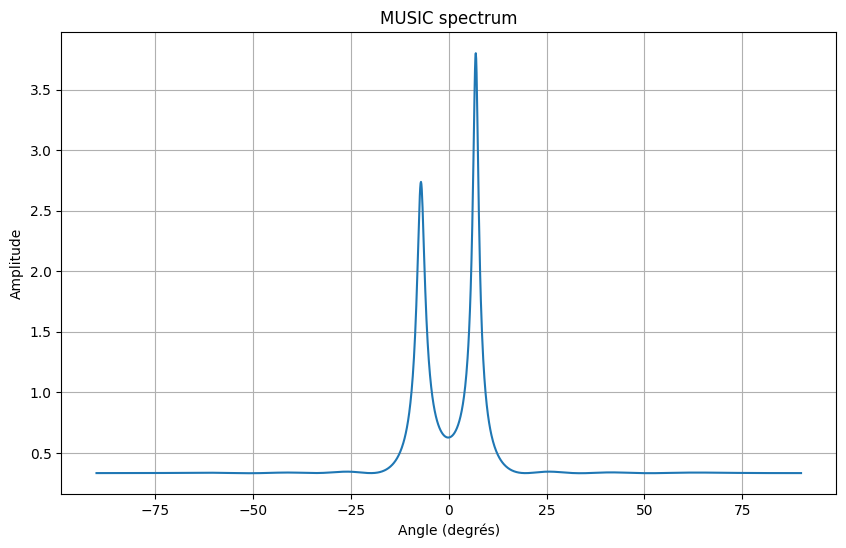

In [ ]:

nbSources = 2 # Nombre de sources
nbSensors = 9 # Nombre de capteurs
nbTimePoints = 100 # Nombre de points temporels
signal_noise_ratio = 3 # Rapport signal sur bruit en décibels. Si 'False', cela revient à une absence totale de bruit.
theta1 = -7 # Angle entre la perpendiculaire à la ligne de capteurs, et la source 1
theta2 = 7 # Angle entre la perpendiculaire à la ligne de capteurs, et la source 2
var_ratio = [2] # Liste qui donne le rapport entre la variance du signal 1 et celui des autres sources (ex: [2, 3] signifie que la source 2 a une variance 2 fois plus grande que la source 1, et la source 3 a une variance 3 fois plus grande que la source 1)
correlation_List = [0.4] # Liste des corrélations. Il y a une corrélation nécéssaire pour chaque paire distincte de sources différentes: 0 pour 1 source, 1 pour 2 sources, 3 pour 3 sources, 6 pour 4 sources etc...
# Ordre de remplisage de la correlation_List: de gauche à droite et ligne par ligne, moitié haut-droite de la matrice uniquement, puis symétrie de ces valeurs pour la moitié bas-gauche
perturbation_parameter_sd = 0.01 # Écart-type de la distribution normale qui génère les erreurs de calibration des capteurs

thetaList = [theta1, theta2]

X = generate_X_matrix(nbSources, nbSensors, nbTimePoints, thetaList, var_ratio, correlation_List, signal_noise_ratio, perturbation_parameter_sd)
estimated_angles = music_method(X, nbSensors, nbSources, print_angles=True, draw_plot=True)

+-